# Comparison of Visibility Noise to Autocorrelations

I examined several differencing schemes for assessing visibility noise and compared that noise to the autocorrelations.

I found that many of these schemes, like the one in [`hera_qm.vis_metrics.check_noise_variance`](https://github.com/HERA-Team/hera_qm/blob/6fdc2d344e6bf277c86781f2ca13c25b30e36903/hera_qm/vis_metrics.py#L14), produce agreement at the $\sim$1% level.

In general, we can think about any differencing scheme as a convolution with a kernel whose sum is 0 (after properly normalizing so that the expected value of the estimator squared is the variance. I looked at a number of such kernels and compared their performance relative to the standard method of noise estimation; autocorrelations scaled by $\sqrt{Bt}$. 

The best one was of the form `[[1,-2,1],[-2,4,-2],[1,-2,1]]`. Given their similarity to the autocorrelations, it looks like using the autocorrelations for scaling Omnical and Abscal $\chi^2$ is the right way forward.

In [6]:
import numpy as np
from hera_cal.io import HERAData
import matplotlib.pyplot as plt
import scipy
%matplotlib notebook

In [2]:
hd = HERAData('zen.2458098.43124.uvh5')
data, flags, nsamples = hd.read(polarizations=['xx'])
ex_ants = [0, 2, 50, 98, 136]
root_Bt = np.sqrt(np.median(np.ediff1d(hd.freqs)) * np.median(np.ediff1d(hd.times)) * 24 * 3600)

<IPython.core.display.Javascript object>


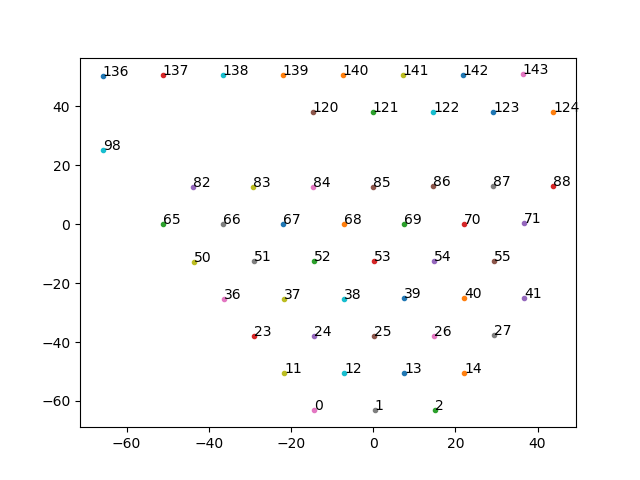

In [7]:
plt.figure()
for ant in data.antpos.keys():
    plt.plot(data.antpos[ant][0], data.antpos[ant][1], '.')
    plt.text(data.antpos[ant][0], data.antpos[ant][1], ant)

<IPython.core.display.Javascript object>


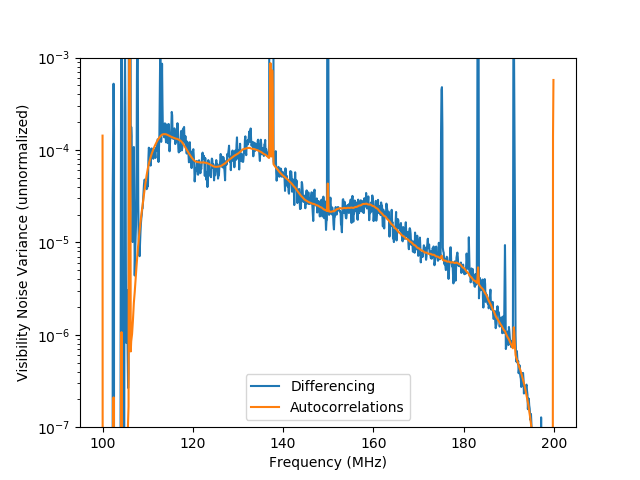

In [8]:
i = 1
j = 138

kernel = [[1,-2,1],[-2,4,-2],[1,-2,1]]
sigma = scipy.signal.convolve2d(data[(i,j,'xx')], kernel, mode='same', boundary='wrap')
sigma /= np.sum(np.array(kernel)**2)**.5
autoi = scipy.signal.convolve2d(data[(i,i,'xx')], np.abs(kernel), mode='same', boundary='wrap') / np.sum(np.abs(kernel))
autoj = scipy.signal.convolve2d(data[(j,j,'xx')], np.abs(kernel), mode='same', boundary='wrap') / np.sum(np.abs(kernel))

plt.figure()
plt.semilogy(data.freqs/1e6, np.mean(np.abs(sigma)**2, axis=0), label='Differencing')
plt.semilogy(data.freqs/1e6, np.mean(np.abs(autoi * autoj) / root_Bt**2, axis=0), label='Autocorrelations')
plt.ylim([1e-7,.001])
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility Noise Variance (unnormalized)')
plt.legend()

In [5]:
kernels = [('2x2 diff', [[1,-1],[-1,1]]),
           ('2D plus', [[0,1,0],[1,-4,1],[0,1,0]]),
           ('2D box', [[1,1,1],[1,-8,1],[1,1,1]]),
           ('2D hybrid', [[1,-2,1],[-2,4,-2],[1,-2,1]]),
           ('1D 2-term', [[1,-1]]),
           ('1D 3-term', [[1,-2,1]]),
           ('1D 5-term', [[-1,4,-6,4,-1]]),
           ('1D 7-term', [[2,-9,18, -22, 18, -9, 2]])]

for kname, kernel in kernels:
    ratios = []
    for i,j,pol in data.keys():
        if i not in ex_ants and j not in ex_ants and i != j:
            sigma = scipy.signal.convolve2d(data[(i,j,'xx')], kernel, mode='same', boundary='wrap')
            sigma /= np.sum(np.array(kernel)**2)**.5
            autoi = scipy.signal.convolve2d(data[(i,i,'xx')], np.abs(kernel), mode='same', boundary='wrap') / np.sum(np.abs(kernel))
            autoj = scipy.signal.convolve2d(data[(j,j,'xx')], np.abs(kernel), mode='same', boundary='wrap') / np.sum(np.abs(kernel))
            ratio = np.sqrt(np.mean(np.abs(sigma)**2, axis=0))
            ratio /= (np.sqrt(np.mean(np.abs(autoi * autoj), axis=0)) / root_Bt)
            ratios.append(np.nanmedian(ratio))
    print kname + ' noise to auto ratio:', np.mean(ratios)

invalid value encountered in divide


2x2 diff noise to auto ratio: 1.0134310903729449
2D plus noise to auto ratio: 1.0649899177951363
2D box noise to auto ratio: 1.1281688911673553
2D hybrid noise to auto ratio: 1.0098488551182356
1D 2-term noise to auto ratio: 1.029156322462887
1D 3-term noise to auto ratio: 1.0130981441497768
1D 5-term noise to auto ratio: 1.0118024244101844
1D 7-term noise to auto ratio: 1.012467082758388
